 <div>
 <h1><center>Applications de l'Informatique Quantique</h1>
<h2><center>Projet Noté : OPTIMISATION </h2>
<h3> Professeur: Durantin Gautier</h3>
<h4> Étudiants: Bonnet Roman, Pages Hugo </h4>
</div>
    
    

### Objectifs du notebook
    
L’établissement du don du sang se demande quels sont les critères (parmi les 4 proposés) qui 
prédisent le mieux la tendance à donner son sang ou non, afin de mettre en place des règles métier 
pour recontacter certains anciens donneurs. On cherche à éviter d’utiliser des features deux à deux 
redondantes.
    
### Imports
    
Le notebook, s'appuie sur deux librairies principales :
- *qiskit* : pour la définition des circuits quantiques et leur préparation pour l'exécution
- *qiskit_aer* : pour la simulation du comportement des ordinateurs quantiques. Le module nous permettra d'exécuter nos circuits en pratique

In [2]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer.primitives import SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.circuit.library import QAOAAnsatz

from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error


from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Visualisation des données
## 1.1 Histogramme
On commence par représenter les données afin de mieux visualiser les differentes catégories.

Remarque : les différentes catégories ayant de valeurs numeriques bien différentes nous utilisons une échelle logarithmique. 

In [3]:
# 1. Chargement et préparation
data = pd.read_csv("transfusion.csv")

name_categories = [
    'Frequency (times)', 
    'Recency (months)', 
    'Monetary (c.c. blood)', 
    'Time (months)'
]

## 1.2 Charactéristiques en fonction des donneurs 

In [4]:
frequency = data['Frequency (times)'].to_numpy()
recency = data['Recency (months)'].to_numpy()
monetary = data['Monetary (c.c. blood)'].to_numpy()
time = data['Time (months)'].to_numpy()

result = data['whether he/she donated blood in March 2007'].to_numpy()
data = [frequency, recency, monetary, time]

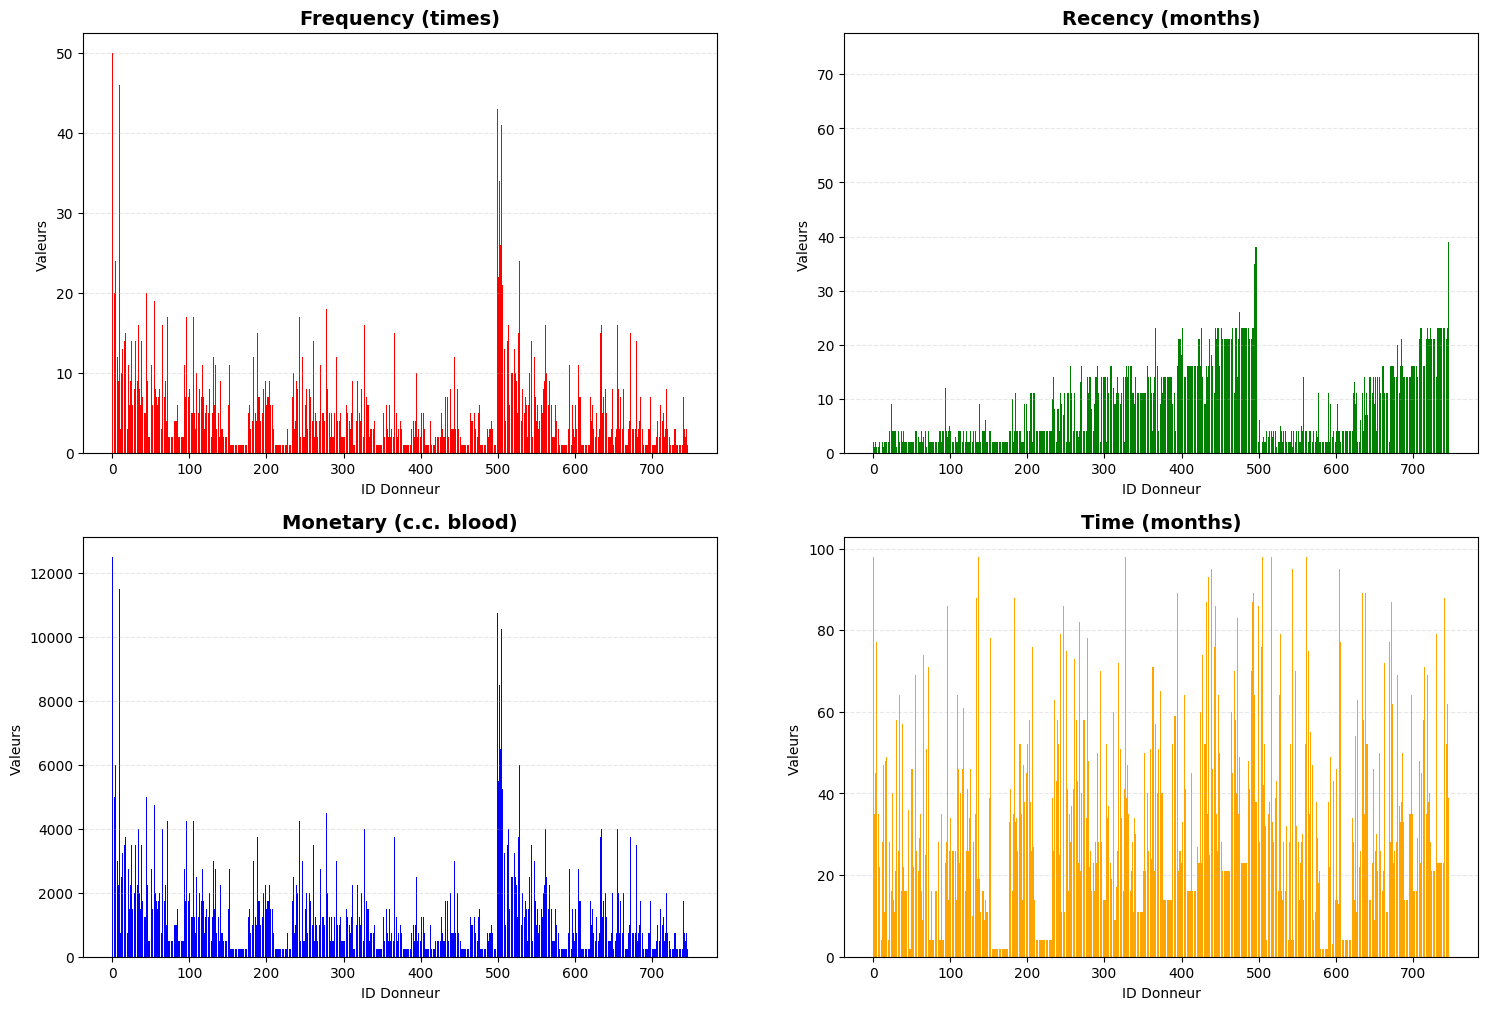

In [5]:
#Chargement de toutes les colonnes

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()
colors=['red', 'green', 'blue', 'orange']
for i, cat in enumerate(data): 
    axes[i].bar(range(len(cat)), cat, label=name_categories[i], color=colors[i])
    axes[i].set_title(f"{name_categories[i]}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("ID Donneur")
    axes[i].set_ylabel("Valeurs ") 
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)

# 2. Formulation du problème d'optimisation sous forme QUBO (Quadratic unconstrained binary optimization): 

Notre objectif est de trouver le set de catégories parmis les suivantes: 
-  Frequency : le nombre total de dons effectués par le donneur 
-  Recency : le nombre de mois écoulés depuis le dernier don du sang. 
-  Monetary : le volume total (en centimètres cubes) de sang donné 
-  Time : le nombre de mois écoulés depuis le premier don du sang

permettant de prévoir si au passage du camion en mars 2007 les donneurs ont donné oui ou non leurs sang. On souhaite éliminer les informations deux à deux redondantes. 

Afin d'appliquer le QAOA qui nécessitera un Hamiltonien, on cherche à se ramener à une forme QUBO de formulation du problème d'optimisation. Pour rappel, les problèmes QUBO sont formulés avec la fonction de coût suivante :

$$ C(X) = X^T Q X + c^T X $$

## 2.1. Construction de $X$ :  

Si on doit choisir parmi $n$ Categories, on note $X=[x_0,x_1,..,x_{n-1}]$ le vecteur décrivant si la catégorie est prise en compte ou non. Les $x_i$ valent tous $0$ ou $1$, et représentent si la categorie est choisi ou pas.

Exemple : $X=[1,0,0,1]$ veut dire que l'on prend en compte le fréquence de don et le nombre de mois écoulés depuis le premier don du sang.

## 2.2. Fonction à optimiser : 

Il est indiqué dans l'énoncé que nous souhaitons les caractèristiques qui prèdisent le mieux le don du sang en mars 2007 et éviter la redondance. Nous appelons $Y=[y_0,y_1,..,y_{n-1}]$ le vecteur binaire qui nous dis si oui ou non le donneur $i$ à donné son sang lors du passage du camion. 
Nous souhaitons donc maximiser la corrélation (ou l'information mutuelle) entre chaque categorie $i$ et la cible $Y$ tout en minimisant la redondance. 
La fonction d'optimisation peut donc s'écrire comme $$H(x) = \underbrace{A\sum_{i \ne j} r_{ij} x_i x_j}_{\text{Redondance}} - \underbrace{B\sum_{i} p_i x_i}_{\text{Pertinence}} + \underbrace{C \left( \sum_{i} x_i - k \right)^2}_{\text{Contrainte}}$$

En ajoutant la contrainte on peut forcer le système à choisir exactement $k$ critères ($k \in \{1, 2, 3\}$). Les coefficients $A$, $B$ et $C$ servent à pondérer les facteurs et donc donner plus ou moins d'importance au respect/non respect des contraintes.

Remarque : L'ajout de la contrainte dans le fonction d'optimisation ne fait pas sortir le problème de la classe "Unconstrainged" nécéssaire à l'élaboration d'un problème QUBO. Dans le cadre d'un QUBO, la fonction doit rester quadratique (de degré 2 maximum) ce qui est bien le cas dans notre definition. 
Si la contrainte est respectée, le terme vaut 0 (pas de coût supplémentaire).

Si la contrainte n'est pas respectée (ex: on choisit 4 critères au lieu de 2), le terme devient positif et très grand, ce qui "pénalise" cette solution.


## 2.3  Incorporation de la contrainte de cardinalité

Nous voulons nous assurer de choisir exactement $k$ features dans un set de 4. Comme expliqué précédemment, un mauvais choix sera pénalisé par un facteur $C (\sum x_i - k)^2$. Le développement de ce terme fournit : $$C (\sum_{i} {x_i}^2 + {\sum_{i\ne j} x_i x_j} - 2k\sum_{i} x_i + k^2)$$

On peut alors négliger le terme $k^2$ qui n'est qu'une constante n'influant pas sur la position du minimum de l'Hamiltonien. De plus, les $x_i$ étant binaires, $x_{i}^2 = x_i$. Le développement du précédent facteur peut alors se résumer à : $$C((1-2k)\sum_{i}{x_i} + {\sum_{i\ne j} x_i x_j})$$

Ce dernier est donc une combinaison d'un terme linéaire et d'un terme quadratique, qui seront donc respectivement des termes diagonaux et hors diagonaux dans notre modèle QUBO final. 

Formulation Finale : $$H(X) = X^T R X + P^T X = \sum_{i\ne j} (Ar_{ij}+C)x_i x_j + \sum_{i} (-Bp_i + C(1-2k))x_i$$ 

Pour trouver le point minimum de cette fonction, nous devons minimiser le premier terme (lié à la redondance) et maximiser la seconde partie (liée à la pertinence du choix des features).
Pour la suite nous posons les expressions respectives de l'opérateur de redondance $R$ et de pertinence $P$ : 
$$ R_{ij} = Ar_{ij}+C \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ P_{i} = -Bp_i + C(1-2k)$$

Les coefficients hors-diagonaux $r_{ij}$ et diagonaux $p_i$. S'obiennent respectivement par le calcul de la corrélation des features entre elles et par le calcul de la valeur absolue de la corrélation entre les features et la cible. Pour ce faire, nous utiliserons la corrélation de Pearson. 

In [6]:
import numpy as np

def build_R_P(features_list, target, k, A=1.0, B=1.0, C=1.0):
    """
    Calcule les paramètres P et R pour un nombre arbitraire de caractéristiques.
    
    Arguments:
    features_list : Liste d'arrays (ex: [recency, frequency, monetary, time])
    target        : Array de la variable cible (0 ou 1)
    k             : Nombre de critères à sélectionner
    A             : Coefficient de poids lié à la redondance
    B             : Coefficient de poids lié à la pertinence
    C             : Facteur de pénalité (Constraint weight)

    Sortie:
    R_eff   : Matrice de Redondance effective
    P_eff   : Matrice de Pertinence effective
    R       : Matice de Redondance
    P       : Matrice de Pertinence
    """
    X = np.array(features_list)
    n = X.shape[0]
    
    # Calcul correlation total entre chaque caractéristique 
    # et la cible, et entre les caractéristiques elles-mêmes
    full_matrix = np.corrcoef(np.vstack([X, target])) 
    
    P = np.abs(full_matrix[:-1, -1]) # Pertinence : corrélation absolue avec la cible
    
    R = full_matrix[:-1, :-1] # Redondance : corrélation entre les caractéristiques
    np.fill_diagonal(R, 0)   # Ignorer la redondance d'une caractéristique avec elle-même

    
    P = A * P
    P_eff = P - C * (1 - 2 * k) # Pénalise les caractéristiques non sélectionnées

    off_diag_mask = np.ones((n, n)) - np.eye(n) # Pour ne pas pénaliser la corrélation d'une feature avec elle-même
    R =  B * R
    R_eff = R + C * off_diag_mask  # Pénalise les redondances entre les caractéristiques sélectionnées
    
    return R_eff, P_eff, R, P


## 3. Initialisation des Parameteres 

On initialise nos coefficients de pertinence, redondance et de contrainte. Noous choisissons de mettre le plus de poids sur le contrainte afin de garantire le bon nombre de caractéristique dans le résultat final. 

$\textit{Note: Les coefficients ont été définis empiriquement.}$

In [7]:
K=1
coeff_P = 0.6 #Coefficient de poids lié à la pertinence
coeff_R = 1.0 #Coefficient de poids lié à la redondance
coeff_C = 1.5 #Coefficient de poids lié à la contrainte du nombre de feature choisi


R_eff, P_eff, R, P = build_R_P(data, result, K, A=coeff_P, B=coeff_R, C=coeff_C)

## 3.1 Representation graphique des matrices de pertiences et redondances  

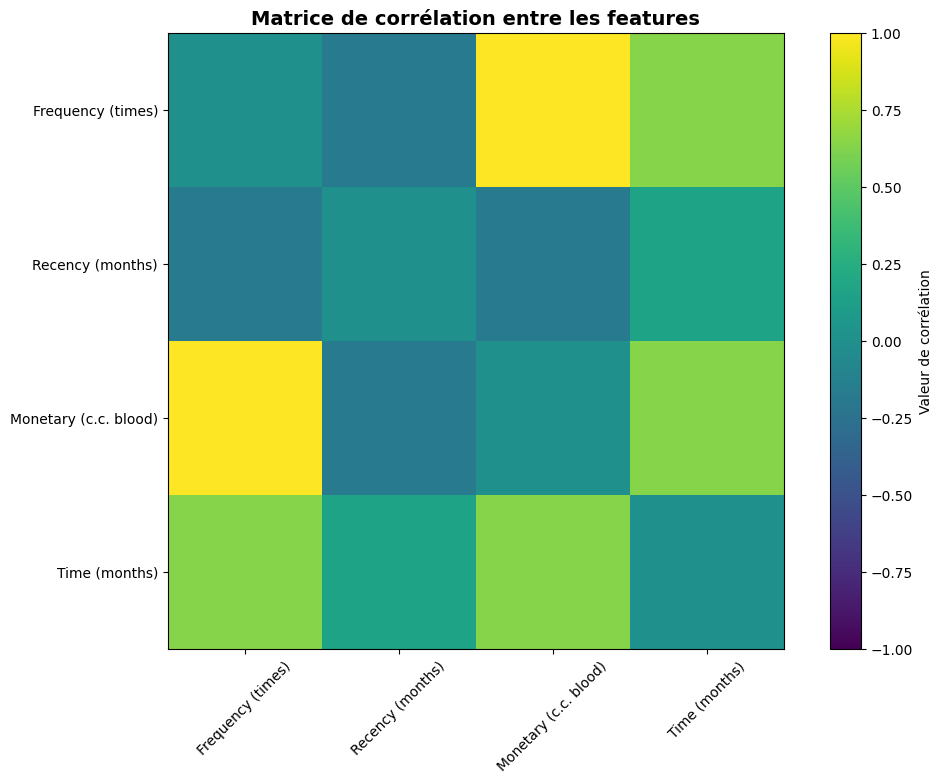

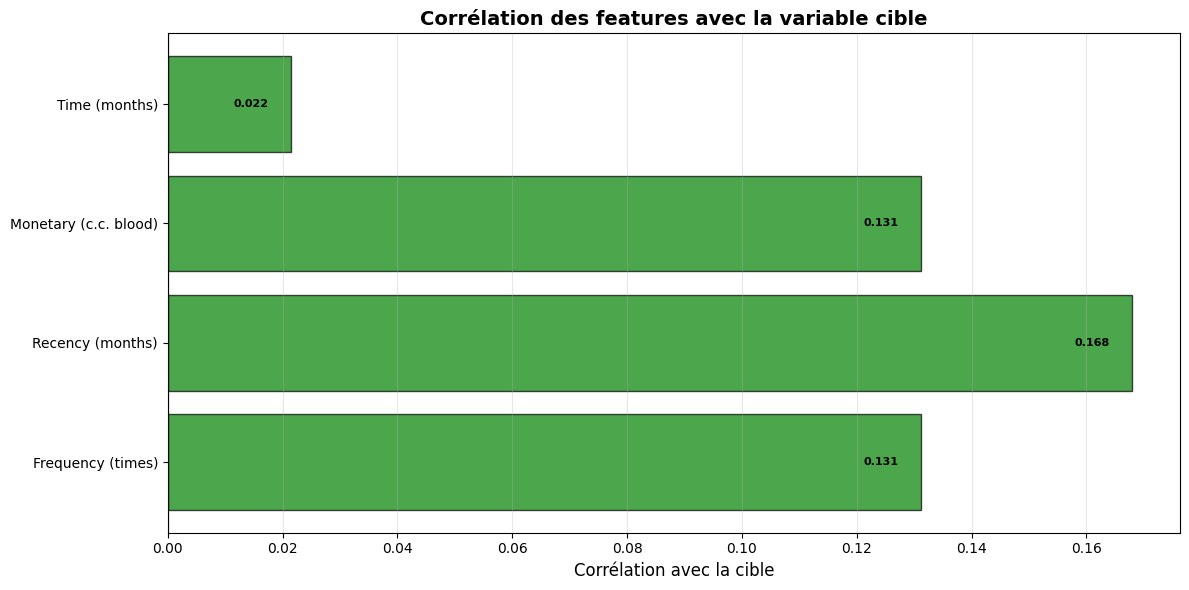

In [8]:
plt.figure(figsize=(12, 8))
plt.imshow(R, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Valeur de corrélation') 
plt.xticks(ticks=np.arange(len(name_categories)), labels=name_categories, rotation=45, fontsize=10)
plt.yticks(ticks=np.arange(len(name_categories)), labels=name_categories, fontsize=10)
plt.title('Matrice de corrélation entre les features', fontsize=14, fontweight='bold')
plt.grid(False)
    
plt.figure(figsize=(12, 6))
colors = ['red' if x < 0 else 'green' for x in P]
bars = plt.barh(name_categories, P, color=colors, alpha=0.7, edgecolor='black')

# Ajouter les valeurs sur les barres
for idx, (bar, val) in enumerate(zip(bars, P)):
    plt.text(val - 0.01 if val > 0 else val + 0.03, idx, 
                 f'{val:.3f}', va='center', ha='left' if val > 0 else 'right',
                 fontweight='bold',
                 fontsize=8)

plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.xlabel('Corrélation avec la cible', fontsize=12)
plt.title('Corrélation des features avec la variable cible', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

## 3.2. Analyse des résultats: 

Le premier plot confirme une corrélation maximale entre les features $\textit{Frequency}$ et $\textit{Monetary}$. A l'inverse nous pouvons voir que les features les moins corrélées entre elles sont $\textit{Frequency}$/$\textit{Monetary}$ et $\textit{Recency}$. Notons que nous avons fait en sorte d'annuler la corrélation d'une feature avec elle même afin que notre modèle n'applique pas de pénalité à un résultat normal et innévitable.

Le deuxième plot représente la valeur absolue de la corrélation entre chaque features et la donnée cible. On peut alors s'apercevoir que la $\textit{Recency}$ est le plus lié aux résultats finaux. Viennent après $\textit{Frequency}$ et $\textit{Monetary}$ puis enfin $\textit{Time}$. Notons que les valeurs liées à $Frequency$ et $Monetary$ sont les mêmes puisque ces datas sont proportionnelles à un facteur près. 

## 3.3. Conclusion 
Nous avons desormais tout les paramètres pour formuler le problème sous la forme QUBO $$ C(X) = X^T R X - P^T X $$
Avec désormais $P_{i} = Bp_i - C(1-2k)$ afin de s'assurer que la minimisation du terme quadratique et que la maximisation du terme linéaire aboutisse à la détermination du minimum. 

# 4. Brut force

In [9]:
def get_criterion(x: np.ndarray, R: np.ndarray,P : np.ndarray):
   return np.dot(x.T, np.dot(R, x)) - np.dot(P, x)

In [10]:
import itertools

K = 1
R_eff, P_eff, R, P = build_R_P(data, result, K, A=coeff_P, B=coeff_R, C=coeff_C)

combinations = list(itertools.product(*[[0,1]]*4))

values = []
for combination in combinations:
  values.append((combination, get_criterion(np.array(combination), R_eff, P_eff)))
  print(combination, values[-1][1])
best= [comb for comb, val in values if val==min(val for _,val in values)]
print("Meilleur set de feature(s) :", best)
print("ce qui correspond à sélectionner les caractéristiques suivantes :")
for i, feature in enumerate(name_categories):
    if best[0][i] == 1:
        print(f"- {feature}")

(0, 0, 0, 0) 0.0
(0, 0, 0, 1) -1.5215126448265548
(0, 0, 1, 0) -1.6311800650858383
(0, 0, 1, 1) 1.1171878307334646
(0, 1, 0, 0) -1.667921320461023
(0, 1, 0, 1) 0.13180222306279177
(0, 1, 1, 0) -0.6645923217109395
(0, 1, 1, 1) 5.405011762458733
(1, 0, 0, 0) -1.6311800650858388
(1, 0, 0, 1) 1.1171878307334637
(1, 0, 1, 0) 1.737639869828321
(1, 0, 1, 1) 8.755888306293482
(1, 1, 0, 0) -0.6645923217109404
(1, 1, 0, 1) 5.405011762458733
(1, 1, 1, 0) 5.338736677039142
(1, 1, 1, 1) 15.678221301854672
Meilleur set de feature(s) : [(0, 1, 0, 0)]
ce qui correspond à sélectionner les caractéristiques suivantes :
- Recency (months)


Ce résultat était tout à fait attendu. En effet, nous observons sur les plots précédents que la feature $\textit{Recency}$ est le plus corrélée avec la cible, donc le choix de cette feature maximise la pertinence. Puisque cette combinaison représente le choix d'une feature unique, la redondance est minimale, et le choix du nombre de feature (ici $K=1$) est respecté.

## 4.1 Brut Force pour différents K

In [11]:
for k in [1,2,3]:
    print(f"k={k}")
    R_eff, P_eff, R, P = build_R_P(data, result, k, A=coeff_P, B=coeff_R, C=coeff_C)
    values = []
    for combination in combinations:
      values.append((combination, get_criterion(np.array(combination), R_eff, P_eff)))
    best= [comb for comb, val in values if val==min(val for _,val in values)]
    print("\t Meilleur set de feature(s) :", best)
    print("\t Ce qui correspond à sélectionner les caractéristiques suivantes :")
    for i, feature in enumerate(name_categories):
        if best[0][i] == 1:
            print(f"\t\t - {feature}")

k=1
	 Meilleur set de feature(s) : [(0, 1, 0, 0)]
	 Ce qui correspond à sélectionner les caractéristiques suivantes :
		 - Recency (months)
k=2
	 Meilleur set de feature(s) : [(1, 1, 0, 0)]
	 Ce qui correspond à sélectionner les caractéristiques suivantes :
		 - Frequency (times)
		 - Recency (months)
k=3
	 Meilleur set de feature(s) : [(0, 1, 1, 0), (1, 1, 0, 0)]
	 Ce qui correspond à sélectionner les caractéristiques suivantes :
		 - Recency (months)
		 - Monetary (c.c. blood)


Les résultats obtenus sont satisfaisant pour les $K=1$ et $K=2$. Cependant, les solutions trouvées pour $K=3$ ne respectent pas la contrainte. Nous avons donc arbitrairement choisi d'augmenter le coefficient lié à ce terme dans le cas $K=3$.

In [36]:
coeffs_P = [0.6, 0.6, 0.6]
coeffs_R = [1, 1, 15]
coeffs_C = [1.5, 1.5, 30]

for k in [1,2,3]:
    print(f"k={k}")
    R_eff, P_eff, R, P = build_R_P(data, result, k, A=coeffs_P[k-1], B=coeffs_R[k-1], C=coeffs_C[k-1])
    values = []
    for combination in combinations:
      values.append((combination, get_criterion(np.array(combination), R_eff, P_eff)))
    best= [comb for comb, val in values if val==min(val for _,val in values)]
    print("\t Meilleur set de feature(s) :", best)
    print("\t Ce qui correspond à sélectionner les caractéristiques suivantes :")
    for i, feature in enumerate(name_categories):
        if best[0][i] == 1:
            print(f"\t\t - {feature}")

k=1
	 Meilleur set de feature(s) : [(0, 1, 0, 0)]
	 Ce qui correspond à sélectionner les caractéristiques suivantes :
		 - Recency (months)
k=2
	 Meilleur set de feature(s) : [(1, 1, 0, 0)]
	 Ce qui correspond à sélectionner les caractéristiques suivantes :
		 - Frequency (times)
		 - Recency (months)
k=3
	 Meilleur set de feature(s) : [(0, 1, 1, 1), (1, 1, 0, 1)]
	 Ce qui correspond à sélectionner les caractéristiques suivantes :
		 - Recency (months)
		 - Monetary (c.c. blood)
		 - Time (months)


La contrainte sur le nombre de feature est cette fois-ci bien respectée. Cependant, le modèle ne semble plus prendre en compte le fait qu'il faut éviter les données redondantes ($Frequency$ et $Monetary$). Nous avons donc du prendre des hautes valeurs de coefficients pour obtenir des résultats satisfaisants. 

## 5. Derivation du Hamiltonien

In [38]:
def get_operator(R: np.ndarray, P : np.ndarray):
    num_nodes = len(P)
    pauli_list = [] #contient la liste des matrices de Pauli à utiliser
    coeffs = [] #contient les coefficients associées à chaque matrice de Pauli

    #Termes en ZiZj
    for i in range(num_nodes):
        for j in range(i):
            if R[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(R[i,j]/2)

    #Termes en Zi
    for i in range(num_nodes):
            x_p = np.zeros(num_nodes, dtype=bool)
            z_p = np.zeros(num_nodes, dtype=bool)
            z_p[i] = True
            pauli_list.append(Pauli((z_p, x_p)))
            coeffs.append(P[i]/2-np.sum(R[i])/2)

    #shift = termes constants
    shift=np.sum(R)/4-np.sum(P)/2
    pauli_list.append('IIII')
    coeffs.append(shift)

    return SparsePauliOp(pauli_list, coeffs=coeffs)

problem_operator = get_operator(R_eff, P_eff)

## 6. QAOA

In [39]:
#paramètres initiaux arbitraires

def get_optimal_qaoa_circuit(r, problem_operator,initial_gamma=np.pi, initial_beta=np.pi/2):
    init_params = [initial_gamma, initial_beta]*r
    circuit=QAOAAnsatz(cost_operator=problem_operator, reps=r)
    
    def cost_func_estimator(params, ansatz, hamiltonian, estimator):
        #Cette fonction estime le coût pour chaque configuration des paramètres, via le calcul de l'espérance mathématique du Hamiltonien.
        pass_manager = generate_preset_pass_manager(1, AerSimulator())
        isa_qc=pass_manager.run(ansatz.assign_parameters(params))
        pub = (isa_qc, hamiltonian)
        job = estimator.run([pub])
        results = job.result()[0]
        cost = results.data.evs
        cost_vals.append(cost)
        return cost
    
    cost_vals=[]
    
    estimator = Estimator()
    estimator.options.default_shots = 10000
    result = minimize(
            cost_func_estimator,
            init_params,
            args=(circuit, problem_operator, estimator),
            method="COBYLA",
            tol=1e-1,
    )
    
    #Definition du circuit optimal pour le QAOA
    optimal_parameters = result.x
    optimal_qaoa_circuit=circuit.assign_parameters(optimal_parameters)
    optimal_qaoa_circuit.measure_all()
    
    return optimal_qaoa_circuit, cost_vals

In [40]:
def run_qaoa_circuit(circuit, depolarizing_error_prob=0):
    pass_manager = generate_preset_pass_manager(1, AerSimulator())
    
    if depolarizing_error_prob > 0:
        noise_model = NoiseModel()
        # Correction : utiliser l'argument de la fonction
        noise_model.add_all_qubit_quantum_error(
            depolarizing_error(depolarizing_error_prob, num_qubits=2), ["cx"]
        )
        sampler = Sampler(options=dict(backend_options=dict(noise_model=noise_model)))
    else:
        sampler = Sampler()
        
    # Correction : utiliser 'circuit' et non la variable globale
    isa_qc = pass_manager.run(circuit)
    job = sampler.run([isa_qc], shots=10000)
    result = job.result()
    return result[0].data.meas.get_counts()

# 7. Simulation

On se propose dans un premier temps de regarder les résultats pour un jeu unique de coefficients:

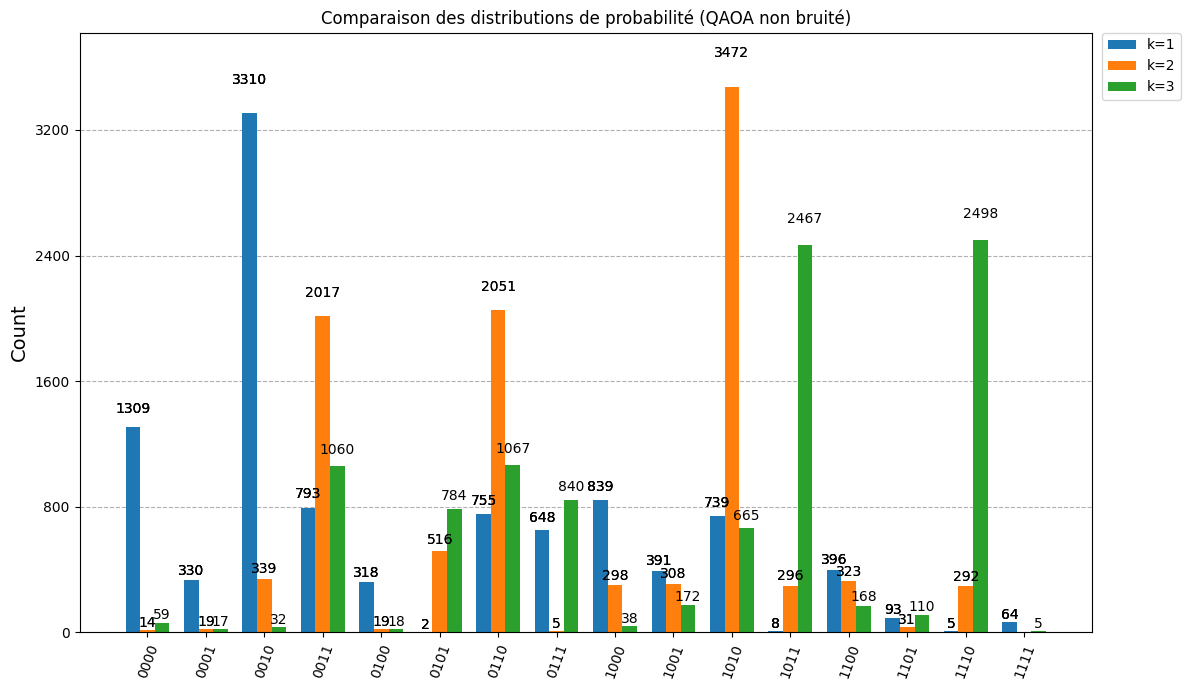

In [41]:
res=[]
    
for k in [1, 2, 3]:
    R, P,_,_ = build_R_P(data, result, k=k, A=coeff_P, B=coeff_R, C=coeff_C)
    problem_operator = get_operator(R, P)
    optimal_qaoa_circuit, cost_vals = get_optimal_qaoa_circuit(r=15, problem_operator=problem_operator)
    counts=run_qaoa_circuit(optimal_qaoa_circuit, depolarizing_error_prob=0)
    res.append(counts)

plot_histogram(res, 
               legend=[f"k={k}" for k in [1, 2, 3]],
               title="Comparaison des distributions de probabilité pour un set de poids unique (QAOA non bruité)",
               figsize=(12, 7))

Il faut noter qu'ici, les sets notés sur l'abscisse sont inversés. Ainsi le set [0010] correspond en réalité au choix de la feature $Recency$

Les résultats pour les différents $k$ sont tout à fait cohérents entre eux. En effet le paramètre $\textit{Recency}$ est utilisé dans toutes les réponses, ce qui valide la prise en compte de la pertinence. La valeur souhaitée de $k$ influe correctement les résultats. Pour finir les données redondantes sont évitées, et nous pouvons observer une symétrie entre les résultats des configurations utilisant soit $\textit{Frequency}$, soit $\textit{Monetary}$. Lorsque ces deux derniers sont dans la même feature, la variable $Count$ chute drastiquement, ce qui traduit un bon respect de la contrainte de redondance. 

Cependant, on se propose de simuler le même programme mais cette fois-ci avec un jeu de coefficients variant en fonction de $k$ (le même que celui établie lors du brut-force, favorisant le respect de la contrainte sur le nombre de features choisis):

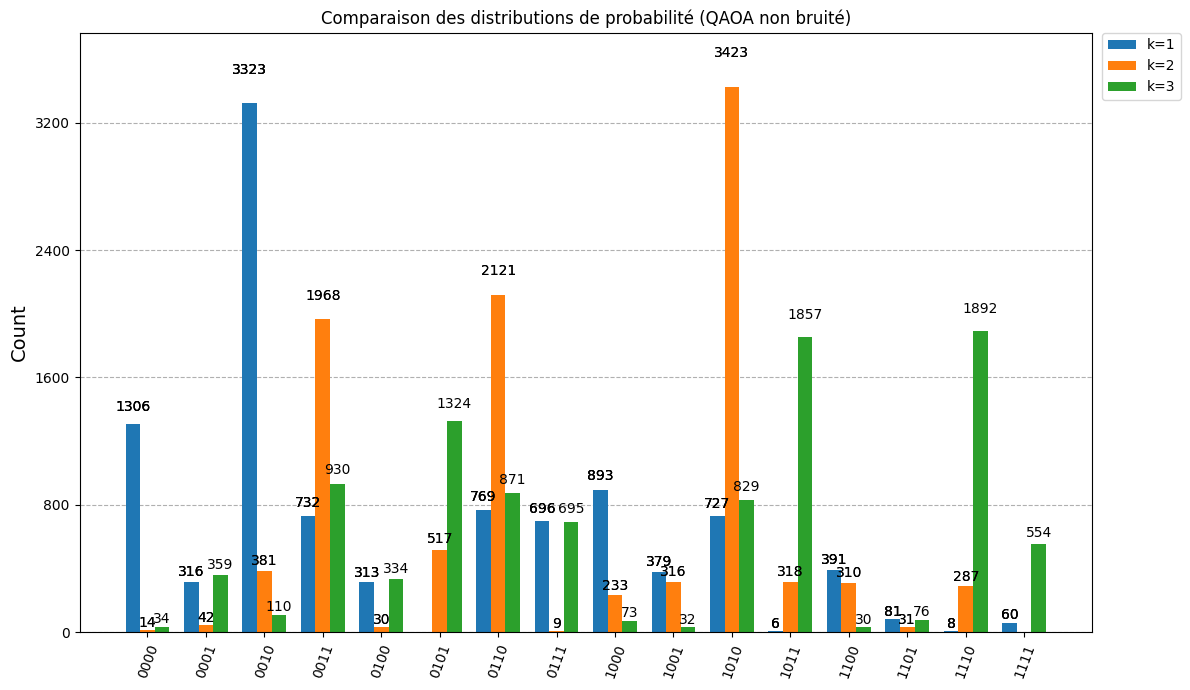

In [ ]:
res=[]
    
for k in [1, 2, 3]:
    R, P,_,_ = build_R_P(data, result, k=k, A=coeffs_P[k-1], B=coeffs_R[k-1], C=coeffs_C[k-1])
    problem_operator = get_operator(R, P)
    optimal_qaoa_circuit, cost_vals = get_optimal_qaoa_circuit(r=15, problem_operator=problem_operator)
    counts=run_qaoa_circuit(optimal_qaoa_circuit, depolarizing_error_prob=0)
    res.append(counts)

plot_histogram(res, 
               legend=[f"k={k}" for k in [1, 2, 3]],
               title="Comparaison des distributions de probabilité pour un set de poids en fonction de k (QAOA non bruité)",
               figsize=(12, 7))

Les résultats concordent, confirmant ainsi notre modèle en comparaison avec les solutions brut-force.

## 8. Influence du bruit

On superpose pour k=1,2 et 3 les histogramme des simulations sans bruit, avec un depolarizing noise de 0.2 et sur une machine virtuelle. 

In [18]:
import pickle
from qiskit_aer.noise import NoiseModel
def fake_backend(qaoa_circuit):
    
    pass_manager = generate_preset_pass_manager(1, AerSimulator())
    with open('ibm_brisbane_eagle.mdl','rb') as f:
        real_noise_dict = pickle.load(f)

    realistic_noise_model = NoiseModel.from_dict(real_noise_dict)

    isa_qaoa_circuit=pass_manager.run(qaoa_circuit)
    #on execute la même expérience sur ce modele
    realistic_sampler = Sampler(options=dict(backend_options=dict(noise_model=realistic_noise_model)))
    job=realistic_sampler.run([isa_qaoa_circuit],shots=10000)
    result=job.result()
    return result[0].data.meas.get_counts()


Processing k=1...


/tmp/ipykernel_50769/460364576.py:9: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  realistic_noise_model = NoiseModel.from_dict(real_noise_dict)


Processing k=2...


/tmp/ipykernel_50769/460364576.py:9: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  realistic_noise_model = NoiseModel.from_dict(real_noise_dict)


Processing k=3...


/tmp/ipykernel_50769/460364576.py:9: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  realistic_noise_model = NoiseModel.from_dict(real_noise_dict)


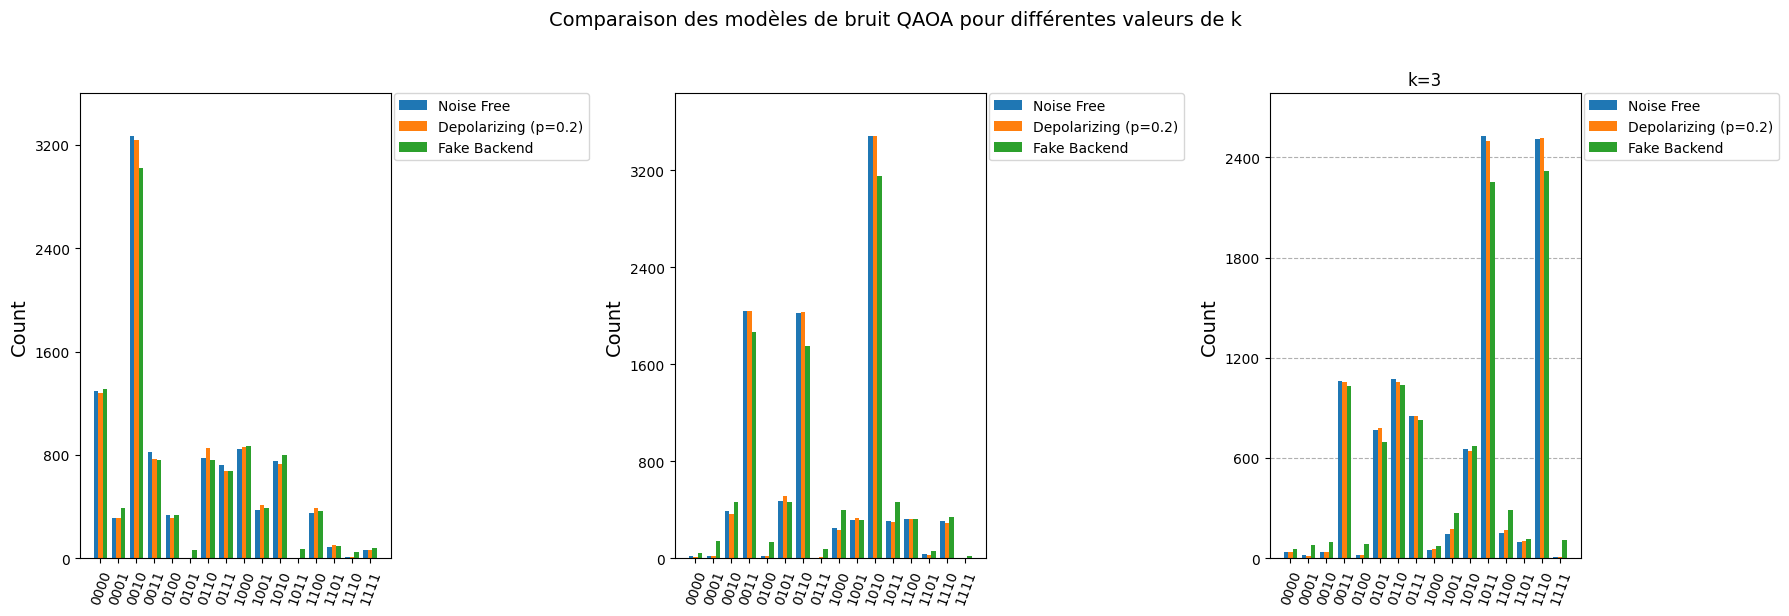

In [19]:
# Stockage des résultats pour chaque k
results_by_k = {}

for k in [1, 2, 3]:
    print(f"Processing k={k}...")
    R, P, _, _ = build_R_P(data, result, k=k, A=coeff_P, B=coeff_R, C=coeff_C)
    problem_operator = get_operator(R, P)
    optimal_qaoa_circuit, cost_vals = get_optimal_qaoa_circuit(r=15, problem_operator=problem_operator)

    counts_noise_free = run_qaoa_circuit(optimal_qaoa_circuit, depolarizing_error_prob=0)
    counts_depolarizing = run_qaoa_circuit(optimal_qaoa_circuit, depolarizing_error_prob=0.2)
    counts_fake_backend = fake_backend(optimal_qaoa_circuit)
    
    results_by_k[k] = {
        'noise_free': counts_noise_free,
        'depolarizing_0.2': counts_depolarizing,
        'fake_backend': counts_fake_backend
    }

# Créer les 3 graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, k in enumerate([1, 2, 3]):
    # Superposer les 3 histogrammes pour chaque k
    plot_histogram(
        [
            results_by_k[k]['noise_free'],
            results_by_k[k]['depolarizing_0.2'],
            results_by_k[k]['fake_backend']
        ],
        legend=['Noise Free', 'Depolarizing (p=0.2)', 'Fake Backend'],
        title=f"k={k}",
        ax=axes[idx],
        bar_labels=False 
    )

plt.suptitle("Comparaison des modèles de bruit QAOA pour différentes valeurs de k", 
             fontsize=14, y=1.02)
plt.tight_layout()


On s'aperçoit ainsi qu'un bruit à 20% n'influence pas les performances de notre modèle, que l'on peut donc qualifier de robuste. 

## 9. Comparaison Brut Force/ Quantique

In [20]:
import time as Time
import tracemalloc
import psutil
import os

from functools import wraps


def benchmark(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Processus actuel
        process = psutil.Process(os.getpid())
        
        # Mesures AVANT l'exécution
        tracemalloc.start()
        cpu_percent_before = process.cpu_percent(interval=0.1)
        mem_before = process.memory_info().rss / 1024 / 1024  # MB
        
        # Temps d'exécution
        start_time = Time.perf_counter()
        start_process_time = Time.process_time()
        
        # Exécution de la fonction
        result = func(*args, **kwargs)
        
        # Temps APRÈS
        end_time = Time.perf_counter()
        end_process_time = Time.process_time()
        
        # Mesures APRÈS l'exécution
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        cpu_percent_after = process.cpu_percent(interval=0.1)
        mem_after = process.memory_info().rss / 1024 / 1024  # MB
        
        # Affichage des résultats
        print(f"\n{'='*60}")
        print(f"Benchmark pour: {func.__name__}")
        print(f"{'='*60}")
        print(f" Temps d'exécution (wall time): {end_time - start_time:.6f} secondes")
        print(f" Temps CPU: {end_process_time - start_process_time:.6f} secondes")
        print(f" Mémoire actuelle utilisée: {current / 1024 / 1024:.2f} MB")
        print(f" Pic de mémoire: {peak / 1024 / 1024:.2f} MB")
        print(f" Mémoire RSS avant: {mem_before:.2f} MB")
        print(f" Mémoire RSS après: {mem_after:.2f} MB")
        print(f" Delta mémoire RSS: {mem_after - mem_before:.2f} MB")
        print(f" CPU% moyen: {(cpu_percent_before + cpu_percent_after) / 2:.2f}%")
        print(f"{'='*60}\n")
        
        return result
    return wrapper

In [33]:
def brut_force_selection(R, P, print_values=True):
    combinations = list(itertools.product(*[[0,1]]*len(P)))
    values = []
    for combination in combinations:
      values.append((combination, get_criterion(np.array(combination), R, P)))
      if print_values:
        print(combination, values[-1][1])
    return values 

In [34]:
@benchmark
def Brut_force_benchmark(P, R):
    values=brut_force_selection(R, P, print_values=False)
    best= [comb for comb, val in values if val==min(val for _,val in values)]
    return 

@benchmark
def Quantique_benchmark(P,R):
    problem_operator = get_operator(R, P)
    optimal_qaoa_circuit, cost_vals = get_optimal_qaoa_circuit(r=3, problem_operator=problem_operator)
    counts=run_qaoa_circuit(optimal_qaoa_circuit, depolarizing_error_prob=0)
    res.append(counts)
    best= max(counts, key=counts.get) 
    return 

In [35]:
K=1
R_eff, P_eff, R, P = build_R_P(data, result, K, A=coeff_P, B=coeff_R, C=coeff_C)

Brut_force_benchmark(P_eff, R_eff)
Quantique_benchmark(P_eff, R_eff)


Benchmark pour: Brut_force_benchmark
 Temps d'exécution (wall time): 0.000391 secondes
 Temps CPU: 0.000390 secondes
 Mémoire actuelle utilisée: 0.00 MB
 Pic de mémoire: 0.04 MB
 Mémoire RSS avant: 824.70 MB
 Mémoire RSS après: 824.70 MB
 Delta mémoire RSS: 0.00 MB
 CPU% moyen: 5.00%


Benchmark pour: Quantique_benchmark
 Temps d'exécution (wall time): 11.776974 secondes
 Temps CPU: 11.922052 secondes
 Mémoire actuelle utilisée: 0.70 MB
 Pic de mémoire: 2.50 MB
 Mémoire RSS avant: 824.70 MB
 Mémoire RSS après: 826.32 MB
 Delta mémoire RSS: 1.62 MB
 CPU% moyen: 0.00%



La simulation quantique est plus coûteuse en temps que la méthode brut-force, mais elle permet d'obtenir des résultats presque totalement similaires à ceux obtenus via le brut-force classique. En effet la seule différence réside dans le cas $k=2$, dans lequel la combinaison de features est différentes.

## 10. Coefficient de corrélation de Fisher

La partie précédente utilise un coefficient de

In [24]:
import numpy as np

data_fisher = np.vstack([frequency, recency, monetary, time]).T

def compute_fisher_score(data, target):
    n_features = data.shape[1]
    fisher_scores = np.zeros(n_features)

    for i in range(n_features):
        feature_val = data[:,i]
        #Séparation par classe
        x1 = feature_val[target == 1]
        x0 = feature_val[target == 0]

        mu1, mu0 = np.mean(x1), np.mean(x0)
        var1, var0 = np.var(x1), np.var(x0)

        fisher_scores[i] = (mu1 - mu0)**2 / (var1 + var0 + 1e-6)
    return fisher_scores

fisher_vector = compute_fisher_score(data_fisher, result)

def build_R_P_Fisher(features_list, target, k, A=1.0, B=1.0, C=1.0):
    """
    Calcule les paramètres P et R pour un nombre arbitraire de caractéristiques.
    
    Arguments:
    features_list : Liste d'arrays (ex: [recency, frequency, monetary, time, ...])
    target        : Array de la variable cible (0 ou 1)
    k             : Nombre de critères à sélectionner
    A             : Poids du paramètres ''
    B             : Poids du paramètres ''
    C             : Facteur de pénalité (Constraint weight)
    """
    X = np.array(features_list)
    n = X.shape[0]
    
    # Calcul correlation total entre chaque caractéristique 
    # et la cible, et entre les caractéristiques elles-mêmes
    full_matrix = np.corrcoef(np.vstack([X, target])) 
    
    P = fisher_vector
    
    R = full_matrix[:-1, :-1] # Redondance : corrélation entre les caractéristiques
    np.fill_diagonal(R, 0)   # Ignorer la redondance d'une caractéristique avec elle-même

    
    P = A * P
    P_eff = P - C * (1 - 2 * k) # Pénalise les caractéristiques non sélectionnées

    off_diag_mask = np.ones((n, n)) - np.eye(n) # Pour ne pas pénaliser la corrélation d'une feature avec elle-même
    R =  B * R
    R_eff = R + C * off_diag_mask  # Pénalise les redondances entre les caractéristiques sélectionnées
    
    return R_eff, P_eff, R, P

In [25]:
K=1

R_eff, P_eff, R, P = build_R_P_Fisher(data, result, K, A=coeff_P, B=coeff_R, C=coeff_C)

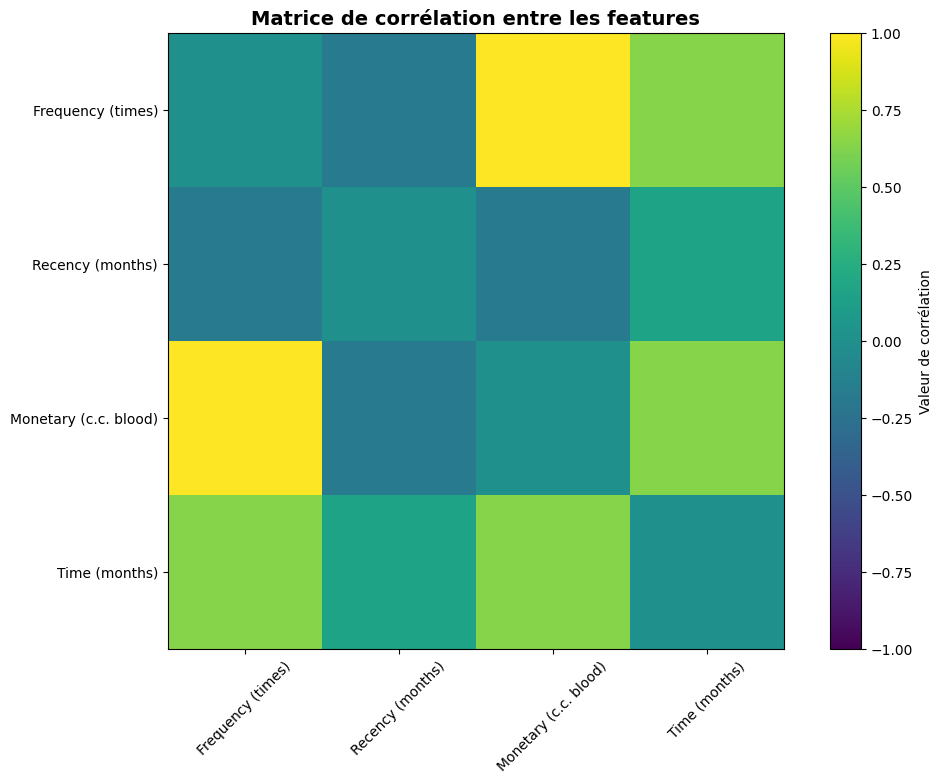

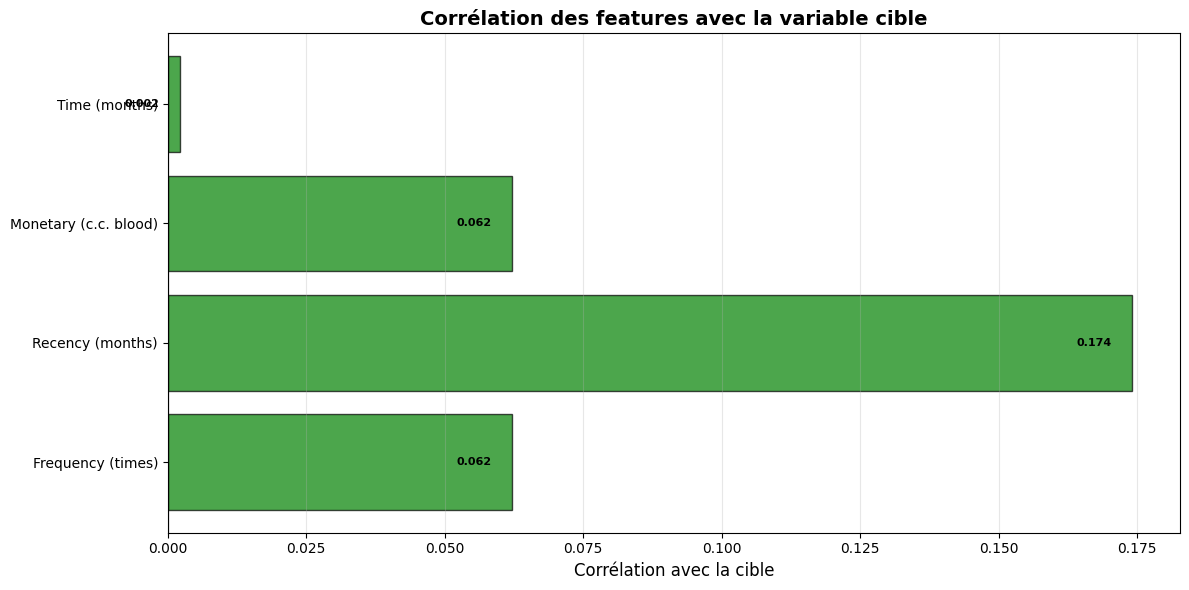

In [26]:
plt.figure(figsize=(12, 8))
plt.imshow(R, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Valeur de corrélation') 
plt.xticks(ticks=np.arange(len(name_categories)), labels=name_categories, rotation=45, fontsize=10)
plt.yticks(ticks=np.arange(len(name_categories)), labels=name_categories, fontsize=10)
plt.title('Matrice de corrélation entre les features', fontsize=14, fontweight='bold')
plt.grid(False)
    
plt.figure(figsize=(12, 6))
colors = ['red' if x < 0 else 'green' for x in P]
bars = plt.barh(name_categories, P, color=colors, alpha=0.7, edgecolor='black')

# Ajouter les valeurs sur les barres
for idx, (bar, val) in enumerate(zip(bars, P)):
    plt.text(val - 0.01 if val > 0 else val + 0.03, idx, 
                 f'{val:.3f}', va='center', ha='left' if val > 0 else 'right',
                 fontweight='bold',
                 fontsize=8)

plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.xlabel('Corrélation avec la cible', fontsize=12)
plt.title('Corrélation des features avec la variable cible', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

In [27]:
R_eff, P_eff, R, P = build_R_P_Fisher(data, result, K, A=coeff_P, B=coeff_R, C=coeff_C)

combinations = list(itertools.product(*[[0,1]]*4))

coeff_P = 0.6
coeff_R = 1.0
coeff_C = 1.5

values = []
for combination in combinations:
  values.append((combination, get_criterion(np.array(combination), R_eff, P_eff)))
  print(combination, values[-1][1])
best= [comb for comb, val in values if val==min(val for _,val in values)]
print("Meilleur set de feature(s) :", best)
print("ce qui correspond à sélectionner les caractéristiques suivantes :")
for i, feature in enumerate(name_categories):
    if best[0][i] == 1:
        print(f"- {feature}")

values = []

(0, 0, 0, 0) 0.0
(0, 0, 0, 1) -1.5021767810545625
(0, 0, 1, 0) -1.5621026240048235
(0, 0, 1, 1) 1.2056011355864715
(0, 1, 0, 0) -1.6740678486251317
(0, 1, 0, 1) 0.1449915586706756
(0, 1, 1, 0) -0.6016614087940333
(0, 1, 1, 1) 5.487278539147631
(1, 0, 0, 0) -1.5621026232887156
(1, 0, 0, 1) 1.2056011363025796
(1, 0, 1, 0) 1.875794752706459
(1, 0, 1, 1) 8.913379052943611
(1, 1, 0, 0) -0.6016614080779257
(1, 1, 0, 1) 5.487278539863739
(1, 1, 1, 0) 5.470745031753172
(1, 1, 1, 1) 15.829565520340694
Meilleur set de feature(s) : [(0, 1, 0, 0)]
ce qui correspond à sélectionner les caractéristiques suivantes :
- Recency (months)


In [28]:
for k in [1,2,3]:
    print(f"k={k}")
    R_eff, P_eff, R, P = build_R_P_Fisher(data, result, k, A=coeffs_P[k-1], B=coeffs_R[k-1], C=coeffs_C[k-1])
    values = []
    for combination in combinations:
      values.append((combination, get_criterion(np.array(combination), R_eff, P_eff)))
    best = [comb for comb, val in values if val==min(val for _,val in values)]
    print("\t Meilleur set de feature(s) :", best)
    print("\t Ce qui correspond à sélectionner les caractéristiques suivantes :")
    for i, feature in enumerate(name_categories):
        if best[0][i] == 1:
            print(f"\t\t - {feature}")

k=1
	 Meilleur set de feature(s) : [(0, 1, 0, 0)]
	 Ce qui correspond à sélectionner les caractéristiques suivantes :
		 - Recency (months)
k=2
	 Meilleur set de feature(s) : [(0, 1, 1, 0)]
	 Ce qui correspond à sélectionner les caractéristiques suivantes :
		 - Recency (months)
		 - Monetary (c.c. blood)
k=3
	 Meilleur set de feature(s) : [(0, 1, 1, 1)]
	 Ce qui correspond à sélectionner les caractéristiques suivantes :
		 - Recency (months)
		 - Monetary (c.c. blood)
		 - Time (months)


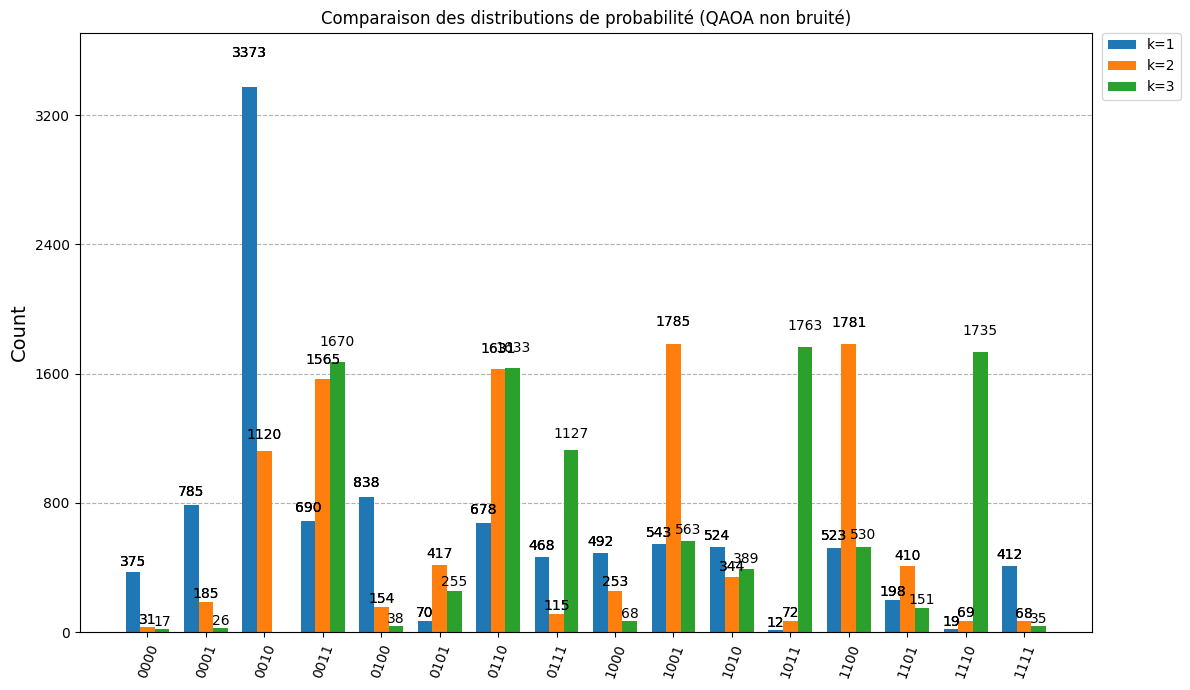

In [29]:
res=[]

for k in [1, 2, 3]:
    R, P,_,_ = build_R_P_Fisher(data, result, k=k, A=coeff_P, B=coeff_R, C=coeff_C)
    problem_operator = get_operator(R, P)
    optimal_qaoa_circuit, cost_vals = get_optimal_qaoa_circuit(r=15, problem_operator=problem_operator)
    counts=run_qaoa_circuit(optimal_qaoa_circuit, depolarizing_error_prob=0)
    res.append(counts)

plot_histogram(res, 
               legend=[f"k={k}" for k in [1, 2, 3]],
               title="Comparaison des distributions de probabilité (QAOA non bruité)",
               figsize=(12, 7))

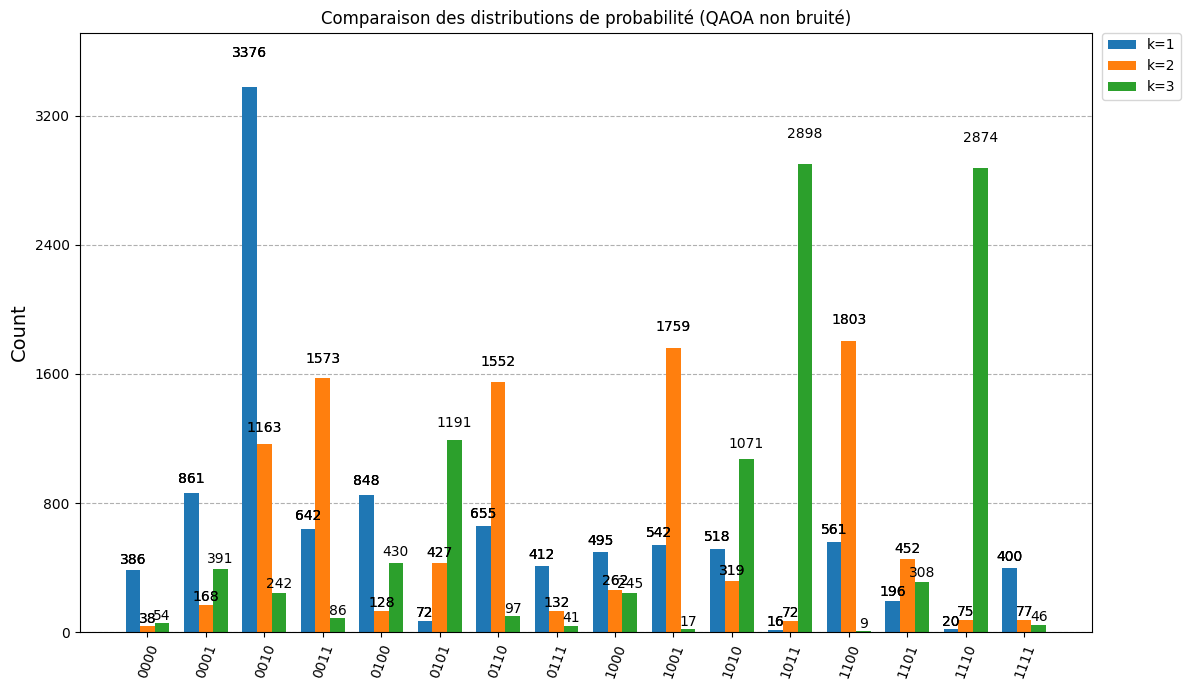

In [42]:
res=[]

coeffs_P = [0.6, 0.6, 0.6]
coeffs_R = [1, 1, 25]
coeffs_C = [1.5, 1.5, 30]

    
for k in [1, 2, 3]:
    R, P,_,_ = build_R_P_Fisher(data, result, k=k, A=coeffs_P[k-1], B=coeffs_R[k-1], C=coeffs_C[k-1])
    problem_operator = get_operator(R, P)
    optimal_qaoa_circuit, cost_vals = get_optimal_qaoa_circuit(r=15, problem_operator=problem_operator)
    counts=run_qaoa_circuit(optimal_qaoa_circuit, depolarizing_error_prob=0)
    # print(counts)
    res.append(counts)

plot_histogram(res, 
               legend=[f"k={k}" for k in [1, 2, 3]],
               title="Comparaison des distributions de probabilité (QAOA non bruité)",
               figsize=(12, 7))